# 🧠 Customer Lifetime Value (LTV) Prediction Model

In [7]:
#Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor, plot_importance
import joblib

In [8]:
#Load Your Dataset
df = pd.read_csv(r'C:\Users\SIDDHANT SHELKE\Pictures\111\online_retail_II.csv', encoding='ISO-8859-1')  # replace with your path if not already in a DataFrame
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,01-12-2009 07:45,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,01-12-2009 07:45,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,01-12-2009 07:45,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,01-12-2009 07:45,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,01-12-2009 07:45,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
1048570,580501,23284,DOORMAT KEEP CALM AND COME IN,2,04-12-2011 13:00,8.25,14546.0,United Kingdom
1048571,580501,22507,MEMO BOARD RETROSPOT DESIGN,3,04-12-2011 13:00,4.95,14546.0,United Kingdom
1048572,580502,22469,HEART OF WICKER SMALL,3,04-12-2011 13:15,1.65,16931.0,United Kingdom
1048573,580502,23489,VINTAGE BELLS GARLAND,2,04-12-2011 13:15,2.89,16931.0,United Kingdom


In [9]:
#Basic Cleaning
df.dropna(subset=['Customer ID'], inplace=True)
df = df[df['Quantity'] > 0]
df = df[df['Price'] > 0]
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], dayfirst=True)


In [10]:
#Create Total Price Column
df['TotalPrice'] = df['Quantity'] * df['Price']

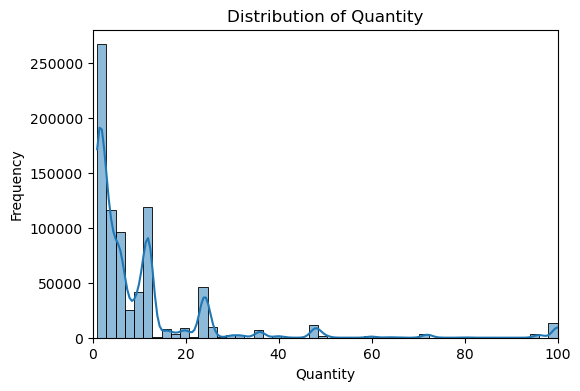

In [11]:
# 📊 Visullation

import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of Quantity
plt.figure(figsize=(6, 4))
sns.histplot(df['Quantity'].clip(upper=100), bins=50, kde=True)
plt.title("Distribution of Quantity")
plt.xlabel("Quantity")
plt.ylabel("Frequency")
plt.xlim(0, 100)
plt.show()

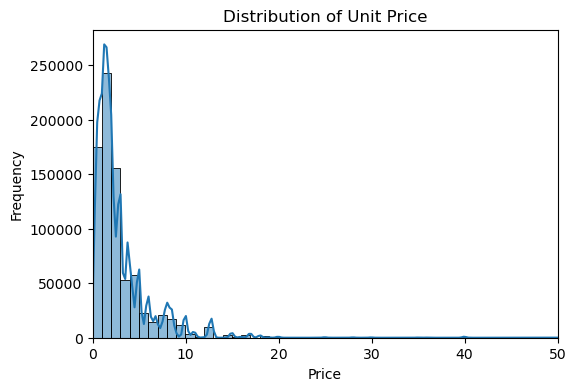

In [12]:
# Distribution of Price
plt.figure(figsize=(6, 4))
sns.histplot(df[df['Price'] < 50]['Price'], bins=50, kde=True)
plt.title("Distribution of Unit Price")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.xlim(0, 50)
plt.show()

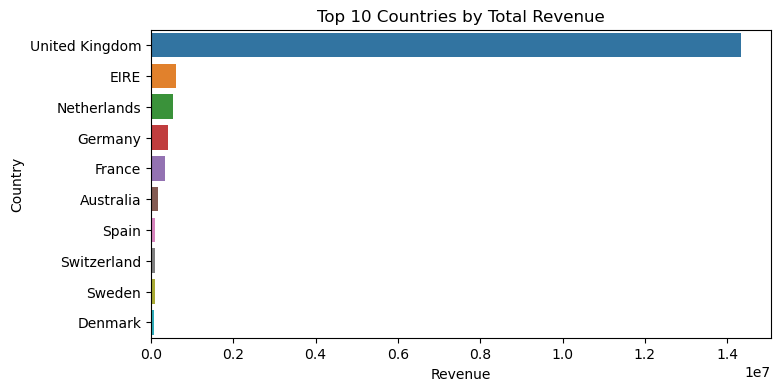

In [13]:
# Total revenue per country (top 10)
revenue_by_country = df.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(8, 4))
sns.barplot(x=revenue_by_country.values, y=revenue_by_country.index)
plt.title("Top 10 Countries by Total Revenue")
plt.xlabel("Revenue")
plt.ylabel("Country")
plt.show()


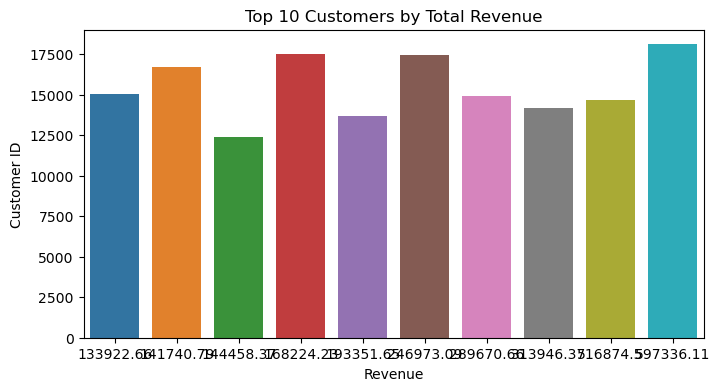

In [14]:
# Top customers by revenue
top_customers = df.groupby('Customer ID')['TotalPrice'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(8, 4))
sns.barplot(x=top_customers.values, y=top_customers.index.astype(int))
plt.title("Top 10 Customers by Total Revenue")
plt.xlabel("Revenue")
plt.ylabel("Customer ID")
plt.show()


In [15]:
#RFM Feature Engineering
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'Invoice': 'nunique',
    'TotalPrice': 'sum'
}).rename(columns={
    'InvoiceDate': 'Recency',
    'Invoice': 'Frequency',
    'TotalPrice': 'Monetary'
})


In [16]:
#Add AOV (Average Order Value)
rfm['AOV'] = rfm['Monetary'] / rfm['Frequency'].replace(0, 1)

In [17]:
#Prepare Features and Target
X = rfm[['Recency', 'Frequency', 'Monetary', 'AOV']]
y = rfm['Monetary']  # Using historical monetary as a proxy for LTV
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [18]:
#Train XGBoost Regressor
model = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [19]:
#Predict and Evaluate
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 980.19
RMSE: 15014.77


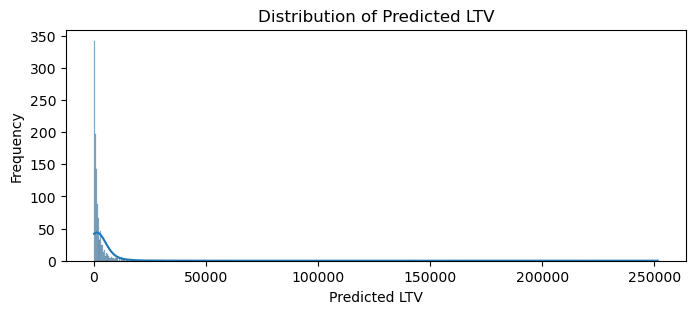

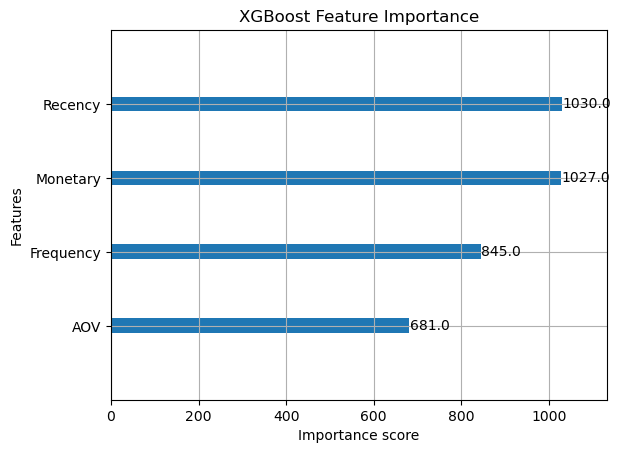

In [20]:
#Visualizations
plt.figure(figsize=(8, 3))
sns.histplot(y_pred, kde=True)
plt.title("Distribution of Predicted LTV")
plt.xlabel("Predicted LTV")
plt.ylabel("Frequency")
plt.show()
plot_importance(model)
plt.title("XGBoost Feature Importance")
plt.show()

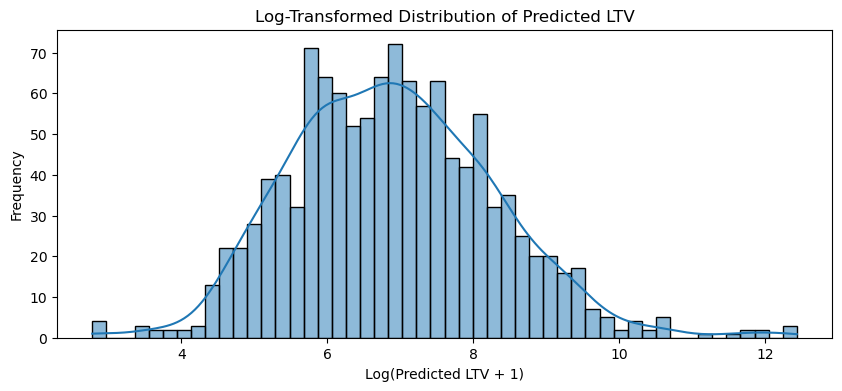

In [26]:
plt.figure(figsize=(10, 4))
sns.histplot(np.log1p(predicted_df['Predicted_LTV']), bins=50, kde=True)
plt.title("Log-Transformed Distribution of Predicted LTV")
plt.xlabel("Log(Predicted LTV + 1)")
plt.ylabel("Frequency")
plt.show()


In [22]:
#Combine and Segment Customers
predicted_df = pd.DataFrame(X_test.copy())
predicted_df['Actual_LTV'] = y_test
predicted_df['Predicted_LTV'] = y_pred
predicted_df['Segment'] = pd.qcut(predicted_df['Predicted_LTV'], q=3, labels=['Low', 'Medium', 'High'])


In [24]:
#Export Outputs
os.makedirs("output", exist_ok=True)
predicted_df.to_csv("output/LTV_predictions.csv", index=False)
joblib.dump(model, "output/xgb_ltv_model.pkl")


['output/xgb_ltv_model.pkl']

In [25]:
# Segment by predicted LTV
rfm['Predicted_LTV'] = model.predict(X)
rfm['Segment'] = pd.qcut(rfm['Predicted_LTV'], q=4, labels=['Low', 'Mid', 'High', 'Top'])

# Save
rfm.to_csv('customer_segments.csv', index=False)
